In [9]:
using HDF5
using Statistics
using Measurements
using Dates

In [2]:
using Plots
gr(
    show = :ijulia, # Dynamically updating plots
    key = false,
    size = (480, 640)
)

Plots.GRBackend()

In [3]:
plotdata = true

true

In [4]:
T(auxV; Tmax = 310.0, Tmin=0.0) = Tmin + (Tmax - Tmin) * (auxV / 10.0)

T (generic function with 1 method)

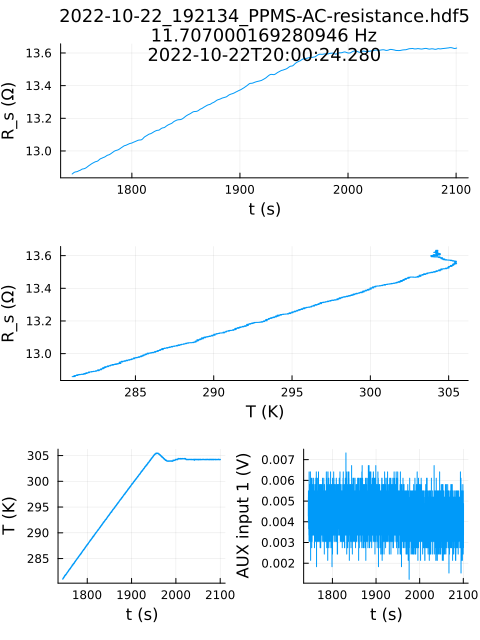

LoadError: InterruptException:

In [15]:
datadir = joinpath("Nowack_Lab_data", "2022-10-20_PPMS-slow-AC-resistance")

activeflag = true

layout = @layout [
    a{1.0w}
    b{1.0w}
    c{0.5w} d{0.5w}
]

 while plotdata
    activeflag != activeflag
    active = activeflag ? "•" : "∘"

    latestdata = readdir(datadir)[end]
    datafile = joinpath(datadir, latestdata)
    
    # opening file in loop is perhaps sub-optimal, but works for now.
    h5open(datafile, "r"; swmr=true) do f
        meta = attrs(f)

        n = 10000
        
        t0 = f["/zurich/initial_timestamp"][]
        tb = f["/zurich/dev505/clockbase"][]
        Rb = f["/setup/bias_resistance"][]
        
        tV = f["/data/zurich/dev505/demods/0/sample/timestamp"][:]
        tI = f["/data/zurich/dev505/demods/1/sample/timestamp"][:]

        commontimes = intersect(tV, tI)
        if length(commontimes) < n
            n = length(commontimes) - 1
        end
        iV = indexin(commontimes, tV)[end-n:end]
        iI = indexin(commontimes, tI)[end-n:end]
        ts = tV[iV] # .== tI[iI]

        Vx = f["/data/zurich/dev505/demods/0/sample/x"][:][iV]
        Vy = f["/data/zurich/dev505/demods/0/sample/y"][:][iV]
        Ix = f["/data/zurich/dev505/demods/1/sample/x"][:][iI]
        Iy = f["/data/zurich/dev505/demods/1/sample/y"][:][iI]

        aux0 = f["/data/zurich/dev505/demods/0/sample/auxin0"][:][iV]
        aux1 = f["/data/zurich/dev505/demods/0/sample/auxin1"][:][iV]
        
        t = (ts .- t0) ./ tb
        A = 100 # SR560 gain
        G = 100.0 # HF2TA V/A
        # Vr = sqrt.(Vx.^2 .+ Vy.^2)
        # Ir = sqrt.(Ix.^2 .+ Iy.^2) ./ Rb
        # R = real.(1e-3 .* Rb .* (Vx .+ im .* Vy) ./ (Ix .+ im .* Iy))
        R = (π/log(2)) .* (Vx ./ A) ./ (-Ix ./ G)
        
        freq = f["/data/zurich/dev505/demods/0/sample/frequency"][end]
        title = join([latestdata, "$(freq) Hz", "$(now())"], "\n")
        # title = latestdata
        
        Ts = T.(aux0; Tmax=310.0)
        
        pRt = plot(t, R;
            xlabel = "t (s)",
            ylabel = "R_s (Ω)",
            show = false,
        )
        pRT = plot(Ts, R;
            xlabel = "T (K)",
            ylabel = "R_s (Ω)",
            show = false,
        )
        paux0 = plot(t, Ts;
            xlabel = "t (s)",
            ylabel = "T (K)",
            show = false,
        )
        paux1 = plot(t, aux1;
            xlabel = "t (s)",
            ylabel = "AUX input 1 (V)",
            show = false,
        )
        plot(pRt, pRT, paux0, paux1;
            layout = layout,
            plot_title = title,
            plot_titlefontsize = 12,
        )
    end
    sleep(1.0)
end